# Raster processing with shapefile
This notebook has 3 tasks: 
1. Generate a square bounding box based on the extent of our shapefile. 
2. Clip our raster file using the square bounding box. In this way, we can get the raster file covering the whole RoI but with the size as small as possible. 
3. Create a raster mask layer based on our shapefile. 

## 1 - Generate the square bounding box based on the extent of our shapefile

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import numpy as np
import pandas as pd
import geopandas as gpd
# 16 Oct 2023: gdal must be imported first, and then rasterio can be imported
from osgeo import gdal
import rasterio as rio

In [2]:
# Set some directories. Here we use absolute directories. 
cwd = 'c:\\Users\\m1865\\Desktop\\Ticino'
cwd_Field = cwd + '\\FieldData'
cwd_Field_Correct = cwd_Field + '\\ShapefileCorretti'
cwd_ProcessedRaster = cwd + '\\ProcessedData'

In [3]:
# Read our corrected shapefile
field_ShpCorrect = gpd.read_file(cwd_Field_Correct)

In [4]:
# Get the bounds of the shapefile [minx miny maxx maxy]
field_ShpCorrect_Box = field_ShpCorrect.total_bounds

In [5]:
# Since all the rasters are square, we need to make our bounding box a square as well. Thanks to the UTM projection, the distances can be measured directly. 
field_distance_x = field_ShpCorrect_Box[2] - field_ShpCorrect_Box[0]
field_distance_y = field_ShpCorrect_Box[3] - field_ShpCorrect_Box[1]
side_length = 0
print("The horizontal distance is " + str(field_distance_x))
print("The vertical distance is " + str(field_distance_y))
if (field_distance_x > field_distance_y):
    print("The side length of the raster should be the horizontal distance, " + str(field_distance_x))
    side_length = field_distance_x
else:
    print("The side length of the raster should be the vertical distance, " + str(field_distance_y))
    side_length = field_distance_y

The horizontal distance is 46114.47985919751
The vertical distance is 68814.38380348403
The side length of the raster should be the vertical distance, 68814.38380348403


<Axes: >

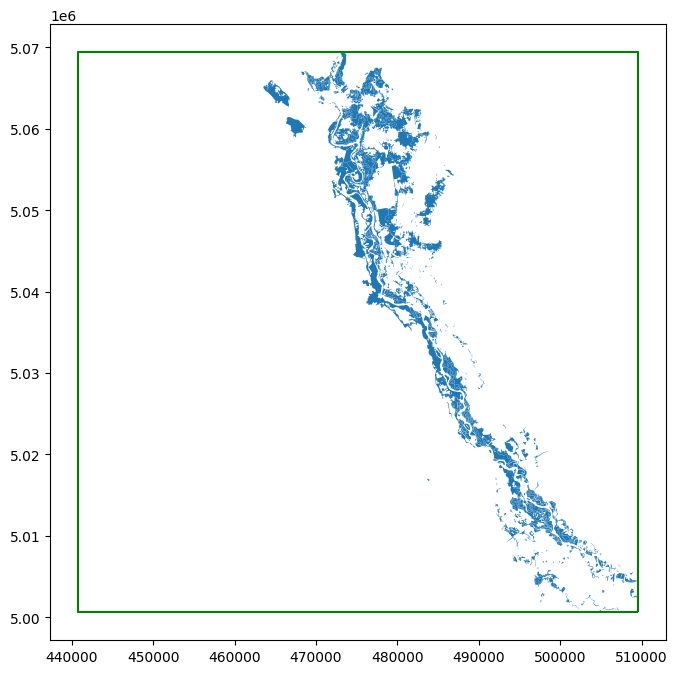

In [6]:
# Create this spatial square
field_Polygon = box(field_ShpCorrect_Box[2]-side_length,field_ShpCorrect_Box[1],field_ShpCorrect_Box[2],field_ShpCorrect_Box[3])
field_Square = gpd.GeoDataFrame(
    [1],
    geometry=[field_Polygon], # Don't forget the [] which makes our polygon into a list
    crs='EPSG:32632'
)
# Plot both the original shapefile and our new square bounding box
fig, ax1 = plt.subplots(1,figsize=(12,8))
field_ShpCorrect.plot(ax=ax1)
field_Square.boundary.plot(ax=ax1,color='green')

## 2 - Clip the raster using the square bounding box

In [7]:
raw_Raster = rio.open(cwd_ProcessedRaster + '\\2022 06')
raw_Raster.tags(ns='ENVI')

{'bands': '10',
 'band_names': '{B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12}',
 'byte_order': '0',
 'coordinate_system_string': '{PROJCS["WGS_1984_UTM_Zone_32N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",9.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]}',
 'data_ignore_value': '-Inf',
 'data_type': '2',
 'default_stretch': '{0.000000 1000.000000 linear}',
 'description': '{ProcessedData/2022 06}',
 'file_type': '{ENVI Standard}',
 'header_offset': '0',
 'interleave': 'bsq',
 'lines': '10980',
 'map_info': '{UTM, 1, 1, 399960, 5100000, 10, 10, 32, North,WGS-84}',
 'samples': '10980',
 'sensor_type': 'Sentinel_2A',
 'wavelength': '{496.6,560,664.5,703.9,740.2,782.5,835.1,864.8,1613.7,2202.4}',
 'wavelength_units': 'na

In [8]:
str_ENVI_hdr_band_names = 'band_names= ' + raw_Raster.tags(ns='ENVI')['band_names']
str_ENVI_hdr_wavelength = 'wavelength= ' + raw_Raster.tags(ns='ENVI')['wavelength']
str_ENVI_hdr_wavelength_units = 'wavelength_units= ' + raw_Raster.tags(ns='ENVI')['wavelength_units']
str_ENVI_hdr_wavelength_units

'wavelength_units= nanometers'

In [9]:
import rasterio.mask
out_image, out_transform = rasterio.mask.mask(raw_Raster,field_Square.geometry,crop=True)
out_meta = raw_Raster.meta


In [10]:
# Save the new raster file to local storage
out_meta.update({"driver": 'ENVI',
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,                    
                 })


with rasterio.open(cwd_ProcessedRaster + '\\2022 06 Cropped', "w", **out_meta) as dest:
    dest.write(out_image)


In [11]:
# Call the custom function to modify the header file, converting it to ENVI header format
import rasterio2ENVIhdr
rasterio2ENVIhdr.rasterio2ENVIhdr(cwd_ProcessedRaster + '\\2022 06 Cropped.hdr',str_ENVI_hdr_band_names,str_ENVI_hdr_wavelength,str_ENVI_hdr_wavelength_units)

Lines after the row 14 will be deleted!


In [12]:
from rasterio.plot import show

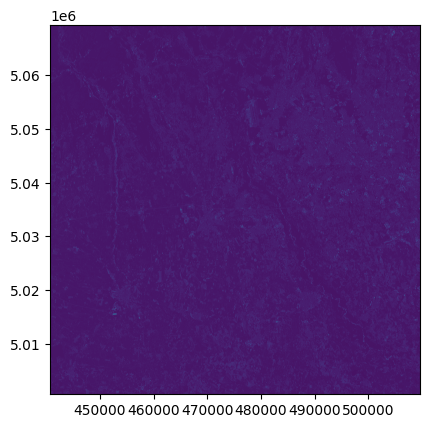

<Axes: >

In [13]:
new_Raster = rio.open(cwd_ProcessedRaster + '\\2022 06 Cropped')
show(new_Raster)

## 3 - Rasterized the shapefile and export it as a mask raster layer
We actually don't need to perform the mask here, since later we will use the R package "biodivR", which requires both the original raster file and the mask raster layer as input, instead of using only the masked raster file as input. 

<Axes: >

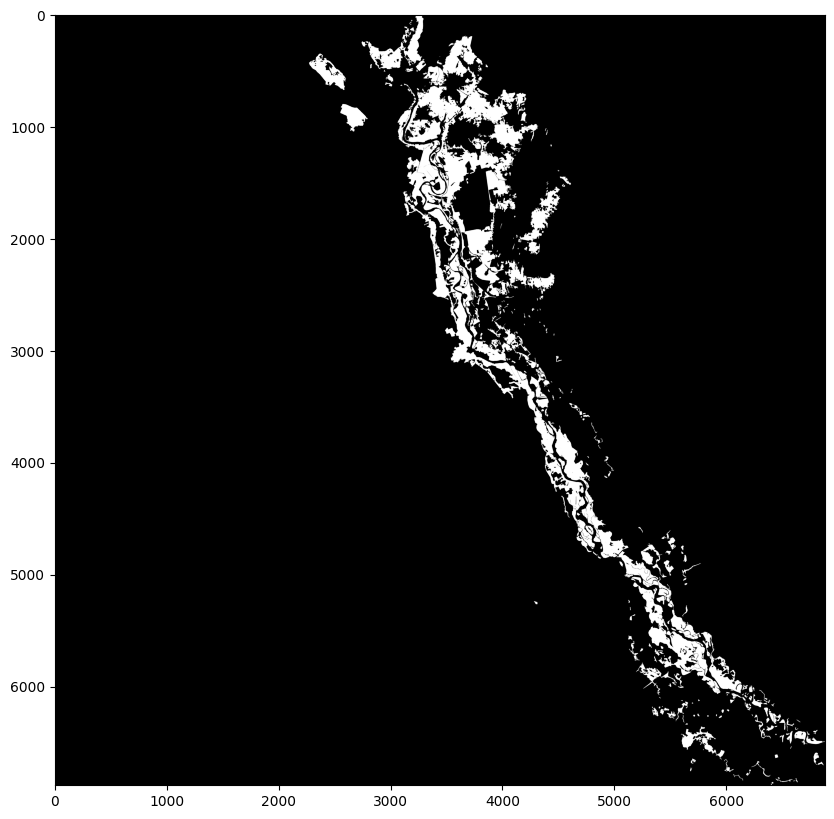

In [14]:
from rasterio import features
# Rasterize vector
rasterized = features.rasterize(field_ShpCorrect.geometry,
                                out_shape = new_Raster.shape,
                                fill = 0,
                                out = None,
                                transform = new_Raster.transform, # "new_Raster.transform" contains information of pixel size and affine
                                all_touched = False,
                                default_value = 1, # 
                                dtype = None)

# Plot rasterized shapefile, since it will be used as a mask, then we choose colormap "Greys_r"
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax, cmap='Greys_r')

In [15]:
# We have rasterized our shapefile to a raster file, but it still has 8 bands and only the first band contains information. 
rasterized_meta = out_meta
rasterized_meta.update(
    count = 1,
)
# Save the rasterized shapefile
with rasterio.open(cwd_ProcessedRaster + '\\2022 06 Mask', "w", **rasterized_meta) as dest:
    dest.write(rasterized,indexes=1)

In [16]:
# Header file to ENVI format
rasterio2ENVIhdr.rasterio2ENVIhdr(cwd_ProcessedRaster + '\\2022 06 Mask.hdr',str_ENVI_hdr_band_names,str_ENVI_hdr_wavelength,str_ENVI_hdr_wavelength_units,is_Mask=True)

Lines after the row 14 will be deleted!
